# <u><center>Comparing Texts Core
- Authored by: Eric N. Valdez
- Date: 03/28/2024

# <u>Comparing Texts:
- In this assignment you will prepare and conduct EDA on a text dataset using SpaCy, NLTK, and WordCount
- The dataet contains labeled real and fake news articles from around the 2017 US Presidential Elections. The dataser was originally from [Kaggle](https://www.kaggle.com/datasets/subhajournal/fake-and-real-news-data) and is licensed under the [GNU AFFERO GERNERLA PUBLIC LICENSE](https://www.gnu.org/licenses/agpl-3.0.html)
  
-  You can also download the data from [here](https://drive.google.com/file/d/16Dqjymk1tdZWPxexs7lM7z1RTk405PAL/view).
  
- If you haven't already, be sure to install SpaCy and download the English language model 

In [1]:
# !pip install spacy
# from spacy.cli import download
# download('en_core_web_sm')

# `Imports:`

In [2]:
import re
import matplotlib.pyplot as plt
import spacy
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import numpy as np
import nltk


from wordcloud import WordCloud
from wordcloud import STOPWORDS
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk import ngrams
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# `Custom Functions & Preprocessing:`

In [3]:
def batch_preprocess_texts(
    texts,
    nlp=None,
    remove_stopwords=True,
    remove_punct=True,
    use_lemmas=False,
    disable=["ner"],
    batch_size=50,
    n_process=-1,
):
    """Efficiently preprocess a collection of texts using nlp.pipe()
    Args:
        texts (collection of strings): collection of texts to process (e.g. df['text'])
        nlp (spacy pipe), optional): Spacy nlp pipe. Defaults to None; if None, it creates a default 'en_core_web_sm' pipe.
        remove_stopwords (bool, optional): Controls stopword removal. Defaults to True.
        remove_punct (bool, optional): Controls punctuation removal. Defaults to True.
        use_lemmas (bool, optional): lemmatize tokens. Defaults to False.
        disable (list of strings, optional): named pipeline elements to disable. Defaults to ["ner"]: Used with nlp.pipe(disable=disable)
        batch_size (int, optional): Number of texts to process in a batch. Defaults to 50.
        n_process (int, optional): Number of CPU processors to use. Defaults to -1 (meaning all CPU cores).
    Returns:
        list of tokens
    """
    # from tqdm.notebook import tqdm
    from tqdm import tqdm
    if nlp is None:
        nlp = spacy.load("en_core_web_sm")
    processed_texts = []
    for doc in tqdm(nlp.pipe(texts, disable=disable, batch_size=batch_size, n_process=n_process)):
        tokens = []
        for token in doc:
            # Check if should remove stopwords and if token is stopword
            if (remove_stopwords == True) and (token.is_stop == True):
                # Continue the loop with the next token
                continue
            # Check if should remove stopwords and if token is stopword
            if (remove_punct == True) and (token.is_punct == True):
                continue
            # Check if should remove stopwords and if token is stopword
            if (remove_punct == True) and (token.is_space == True):
                continue
            
            ## Determine final form of output list of tokens/lemmas
            if use_lemmas:
                tokens.append(token.lemma_.lower())
            else:
                tokens.append(token.text.lower())
        processed_texts.append(tokens)
    return processed_texts


In [4]:
# Increase column width
pd.set_option('display.max_colwidth', 250)

# `Load Data:`

In [5]:
fpath = 'Data/Fake_Real_News_Data.csv'
df=pd.read_csv(fpath)
df.head()

,Unnamed: 0,title,text,label
0,0,A whirlwind day in D.C. showcases Trump’s unorthodox views and shifting tone,"Donald Trump endorsed an unabashedly noninterventionist approach to world affairs Monday during a day-long tour of Washington, casting doubt on the need for the North Atlantic Treaty Organization and expressing skepticism about a muscular U.S. mi...",REAL
1,1,"In Baltimore's call for federal police probe, a new search for answers (+video)","While some Justice Department investigations are adversarial, a new model of collaborative reform is surprising police in some cities, as they find themselves included as part of the solution.\n\nSearching for a ""framework ... [to] heal,"" Baltimo...",REAL
2,2,Trump Proudly Declares: Most Of The People I’ve Insulted Deserved It,"Trump Proudly Declares: Most Of The People I’ve Insulted Deserved It By Andrew Bradford on October 27, 2016 Subscribe \nArrogance is defined as “an insulting way of thinking or behaving that comes from believing that you are better, smarter, or m...",FAKE
3,3,Inside the Trump-Bush melodrama: Decades of tension and discomfort,"Donald Trump spent a day in January 2014 hobnobbing with politicians at the Trump International Golf Club in West Palm Beach, Fla. The billionaire mogul touted legalizing gambling with state Rep. Steve Crisafulli, speaker of the Florida House, an...",REAL
4,4,Shutdown clash to return in force by December,"Notable names include Ray Washburne (Commerce), a Dallas-based investor, is reported to be under consideration to lead the department.",REAL


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
 3   label       6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB


## **1. Clean the Data**
- Remove any unnecessary columns and check for/ remove duplicates.

In [7]:
df = df.drop('Unnamed: 0', axis=1)
df.head()

,title,text,label
0,A whirlwind day in D.C. showcases Trump’s unorthodox views and shifting tone,"Donald Trump endorsed an unabashedly noninterventionist approach to world affairs Monday during a day-long tour of Washington, casting doubt on the need for the North Atlantic Treaty Organization and expressing skepticism about a muscular U.S. mi...",REAL
1,"In Baltimore's call for federal police probe, a new search for answers (+video)","While some Justice Department investigations are adversarial, a new model of collaborative reform is surprising police in some cities, as they find themselves included as part of the solution.\n\nSearching for a ""framework ... [to] heal,"" Baltimo...",REAL
2,Trump Proudly Declares: Most Of The People I’ve Insulted Deserved It,"Trump Proudly Declares: Most Of The People I’ve Insulted Deserved It By Andrew Bradford on October 27, 2016 Subscribe \nArrogance is defined as “an insulting way of thinking or behaving that comes from believing that you are better, smarter, or m...",FAKE
3,Inside the Trump-Bush melodrama: Decades of tension and discomfort,"Donald Trump spent a day in January 2014 hobnobbing with politicians at the Trump International Golf Club in West Palm Beach, Fla. The billionaire mogul touted legalizing gambling with state Rep. Steve Crisafulli, speaker of the Florida House, an...",REAL
4,Shutdown clash to return in force by December,"Notable names include Ray Washburne (Commerce), a Dallas-based investor, is reported to be under consideration to lead the department.",REAL


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   6335 non-null   object
 1   text    6335 non-null   object
 2   label   6335 non-null   object
dtypes: object(3)
memory usage: 148.6+ KB


In [9]:
df.duplicated().sum()

29

In [10]:
df = df.drop_duplicates()
df.duplicated().sum()

0

## **2. Prepare the Data** - Create 3 new columns:
- Tokenized texts: `just split the texts, don't remove stop words or punctuation`- Lemmatized texts: `remove stopwords, and punctuation, and lemmatize the words`
    - `IMPORTANT!` When you load in the SpaCy NLP object, <u>remember</u> to disable the parser and named object recognizer using the following: `spacy.load('en_core_web_sm, disable = ['parser', 'ner')`
- Joined lemmatized data.a
    -Join each lemmatized document into a single string.g.

<u> Tolkenize Texts:

In [11]:
df['tokens'] = df['text'].map(lambda doc: doc.lower().split())
df.head()

,title,text,label,tokens
0,A whirlwind day in D.C. showcases Trump’s unorthodox views and shifting tone,"Donald Trump endorsed an unabashedly noninterventionist approach to world affairs Monday during a day-long tour of Washington, casting doubt on the need for the North Atlantic Treaty Organization and expressing skepticism about a muscular U.S. mi...",REAL,"[donald, trump, endorsed, an, unabashedly, noninterventionist, approach, to, world, affairs, monday, during, a, day-long, tour, of, washington,, casting, doubt, on, the, need, for, the, north, atlantic, treaty, organization, and, expressing, skep..."
1,"In Baltimore's call for federal police probe, a new search for answers (+video)","While some Justice Department investigations are adversarial, a new model of collaborative reform is surprising police in some cities, as they find themselves included as part of the solution.\n\nSearching for a ""framework ... [to] heal,"" Baltimo...",REAL,"[while, some, justice, department, investigations, are, adversarial,, a, new, model, of, collaborative, reform, is, surprising, police, in, some, cities,, as, they, find, themselves, included, as, part, of, the, solution., searching, for, a, ""fra..."
2,Trump Proudly Declares: Most Of The People I’ve Insulted Deserved It,"Trump Proudly Declares: Most Of The People I’ve Insulted Deserved It By Andrew Bradford on October 27, 2016 Subscribe \nArrogance is defined as “an insulting way of thinking or behaving that comes from believing that you are better, smarter, or m...",FAKE,"[trump, proudly, declares:, most, of, the, people, i’ve, insulted, deserved, it, by, andrew, bradford, on, october, 27,, 2016, subscribe, arrogance, is, defined, as, “an, insulting, way, of, thinking, or, behaving, that, comes, from, believing, t..."
3,Inside the Trump-Bush melodrama: Decades of tension and discomfort,"Donald Trump spent a day in January 2014 hobnobbing with politicians at the Trump International Golf Club in West Palm Beach, Fla. The billionaire mogul touted legalizing gambling with state Rep. Steve Crisafulli, speaker of the Florida House, an...",REAL,"[donald, trump, spent, a, day, in, january, 2014, hobnobbing, with, politicians, at, the, trump, international, golf, club, in, west, palm, beach,, fla., the, billionaire, mogul, touted, legalizing, gambling, with, state, rep., steve, crisafulli,..."
4,Shutdown clash to return in force by December,"Notable names include Ray Washburne (Commerce), a Dallas-based investor, is reported to be under consideration to lead the department.",REAL,"[notable, names, include, ray, washburne, (commerce),, a, dallas-based, investor,, is, reported, to, be, under, consideration, to, lead, the, department.]"


<u>Lemmatized Texts:

In [12]:
nlp_lite = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
nlp_lite

In [13]:
df['lemmatized_tokens'] = batch_preprocess_texts(df['text'], nlp=nlp_lite,use_lemmas=True)
df.head()

6306it [04:04, 25.83it/s] 


,title,text,label,tokens,lemmatized_tokens
0,A whirlwind day in D.C. showcases Trump’s unorthodox views and shifting tone,"Donald Trump endorsed an unabashedly noninterventionist approach to world affairs Monday during a day-long tour of Washington, casting doubt on the need for the North Atlantic Treaty Organization and expressing skepticism about a muscular U.S. mi...",REAL,"[donald, trump, endorsed, an, unabashedly, noninterventionist, approach, to, world, affairs, monday, during, a, day-long, tour, of, washington,, casting, doubt, on, the, need, for, the, north, atlantic, treaty, organization, and, expressing, skep...","[donald, trump, endorse, unabashedly, noninterventionist, approach, world, affair, monday, day, long, tour, washington, cast, doubt, need, north, atlantic, treaty, organization, express, skepticism, muscular, u.s., military, presence, asia, forei..."
1,"In Baltimore's call for federal police probe, a new search for answers (+video)","While some Justice Department investigations are adversarial, a new model of collaborative reform is surprising police in some cities, as they find themselves included as part of the solution.\n\nSearching for a ""framework ... [to] heal,"" Baltimo...",REAL,"[while, some, justice, department, investigations, are, adversarial,, a, new, model, of, collaborative, reform, is, surprising, police, in, some, cities,, as, they, find, themselves, included, as, part, of, the, solution., searching, for, a, ""fra...","[justice, department, investigation, adversarial, new, model, collaborative, reform, surprising, police, city, find, include, solution, search, framework, heal, baltimore, mayor, stephanie, rawlings, blake, 911, department, justice, ask, civil, r..."
2,Trump Proudly Declares: Most Of The People I’ve Insulted Deserved It,"Trump Proudly Declares: Most Of The People I’ve Insulted Deserved It By Andrew Bradford on October 27, 2016 Subscribe \nArrogance is defined as “an insulting way of thinking or behaving that comes from believing that you are better, smarter, or m...",FAKE,"[trump, proudly, declares:, most, of, the, people, i’ve, insulted, deserved, it, by, andrew, bradford, on, october, 27,, 2016, subscribe, arrogance, is, defined, as, “an, insulting, way, of, thinking, or, behaving, that, comes, from, believing, t...","[trump, proudly, declare, people, insult, deserved, andrew, bradford, october, 27, 2016, subscribe, arrogance, define, insulting, way, thinking, behave, come, believe, well, smart, important, people, word, donald, trump, perfectly, exemplify, arr..."
3,Inside the Trump-Bush melodrama: Decades of tension and discomfort,"Donald Trump spent a day in January 2014 hobnobbing with politicians at the Trump International Golf Club in West Palm Beach, Fla. The billionaire mogul touted legalizing gambling with state Rep. Steve Crisafulli, speaker of the Florida House, an...",REAL,"[donald, trump, spent, a, day, in, january, 2014, hobnobbing, with, politicians, at, the, trump, international, golf, club, in, west, palm, beach,, fla., the, billionaire, mogul, touted, legalizing, gambling, with, state, rep., steve, crisafulli,...","[donald, trump, spend, day, january, 2014, hobnob, politician, trump, international, golf, club, west, palm, beach, fla., billionaire, mogul, tout, legalize, gambling, state, rep., steve, crisafulli, speaker, florida, house, wire, florida, republ..."
4,Shutdown clash to return in force by December,"Notable names include Ray Washburne (Commerce), a Dallas-based investor, is reported to be under consideration to lead the department.",REAL,"[notable, names, include, ray, washburne, (commerce),, a, dallas-based, investor,, is, reported, to, be, under, consideration, to, lead, the, department.]","[notable, name, include, ray, washburne, commerce, dallas, base, investor, report, consideration, lead, department]"


## **3. Analyze class balance and document lengths:**
- What is the class balance? How many real and fake articles are there?
- What is the average word count for real news articles? What about fake ones?
- `Hint`, you can map the len() function to the tolkenized text to create a new column, then find the average of that column.

In [14]:
df['length'] = df['tokens'].map(len)
df.head()

,title,text,label,tokens,lemmatized_tokens,length
0,A whirlwind day in D.C. showcases Trump’s unorthodox views and shifting tone,"Donald Trump endorsed an unabashedly noninterventionist approach to world affairs Monday during a day-long tour of Washington, casting doubt on the need for the North Atlantic Treaty Organization and expressing skepticism about a muscular U.S. mi...",REAL,"[donald, trump, endorsed, an, unabashedly, noninterventionist, approach, to, world, affairs, monday, during, a, day-long, tour, of, washington,, casting, doubt, on, the, need, for, the, north, atlantic, treaty, organization, and, expressing, skep...","[donald, trump, endorse, unabashedly, noninterventionist, approach, world, affair, monday, day, long, tour, washington, cast, doubt, need, north, atlantic, treaty, organization, express, skepticism, muscular, u.s., military, presence, asia, forei...",1428
1,"In Baltimore's call for federal police probe, a new search for answers (+video)","While some Justice Department investigations are adversarial, a new model of collaborative reform is surprising police in some cities, as they find themselves included as part of the solution.\n\nSearching for a ""framework ... [to] heal,"" Baltimo...",REAL,"[while, some, justice, department, investigations, are, adversarial,, a, new, model, of, collaborative, reform, is, surprising, police, in, some, cities,, as, they, find, themselves, included, as, part, of, the, solution., searching, for, a, ""fra...","[justice, department, investigation, adversarial, new, model, collaborative, reform, surprising, police, city, find, include, solution, search, framework, heal, baltimore, mayor, stephanie, rawlings, blake, 911, department, justice, ask, civil, r...",1091
2,Trump Proudly Declares: Most Of The People I’ve Insulted Deserved It,"Trump Proudly Declares: Most Of The People I’ve Insulted Deserved It By Andrew Bradford on October 27, 2016 Subscribe \nArrogance is defined as “an insulting way of thinking or behaving that comes from believing that you are better, smarter, or m...",FAKE,"[trump, proudly, declares:, most, of, the, people, i’ve, insulted, deserved, it, by, andrew, bradford, on, october, 27,, 2016, subscribe, arrogance, is, defined, as, “an, insulting, way, of, thinking, or, behaving, that, comes, from, believing, t...","[trump, proudly, declare, people, insult, deserved, andrew, bradford, october, 27, 2016, subscribe, arrogance, define, insulting, way, thinking, behave, come, believe, well, smart, important, people, word, donald, trump, perfectly, exemplify, arr...",408
3,Inside the Trump-Bush melodrama: Decades of tension and discomfort,"Donald Trump spent a day in January 2014 hobnobbing with politicians at the Trump International Golf Club in West Palm Beach, Fla. The billionaire mogul touted legalizing gambling with state Rep. Steve Crisafulli, speaker of the Florida House, an...",REAL,"[donald, trump, spent, a, day, in, january, 2014, hobnobbing, with, politicians, at, the, trump, international, golf, club, in, west, palm, beach,, fla., the, billionaire, mogul, touted, legalizing, gambling, with, state, rep., steve, crisafulli,...","[donald, trump, spend, day, january, 2014, hobnob, politician, trump, international, golf, club, west, palm, beach, fla., billionaire, mogul, tout, legalize, gambling, state, rep., steve, crisafulli, speaker, florida, house, wire, florida, republ...",1959
4,Shutdown clash to return in force by December,"Notable names include Ray Washburne (Commerce), a Dallas-based investor, is reported to be under consideration to lead the department.",REAL,"[notable, names, include, ray, washburne, (commerce),, a, dallas-based, investor,, is, reported, to, be, under, consideration, to, lead, the, department.]","[notable, name, include, ray, washburne, commerce, dallas, base, investor, report, consideration, lead, department]",19


In [15]:
df['lemmas-joined'] = df['lemmatized_tokens'].map(lambda x: ' '.join(x))

In [16]:
real = df[df['label']== 'REAL']
fake = df[df['label']== 'FAKE']

In [17]:
print(f'There are {len(real)} Real News Articles.')
print(f'There are {len(fake)} Fake News Articles.')

There are 3154 Real News Articles.
There are 3152 Fake News Articles.


In [18]:
print(f"Real News Articles are an average length of {real['length'].mean().round(2)} words")
print(f"Fake News Articles are an average length of {fake['length'].mean().round(2)} words")

Real News Articles are an average length of 873.7 words
Fake News Articles are an average length of 678.93 words


## **4. Compare the word frequencies:**
- Create and plot the frequency distribution plots for the 20 most common words in real and fake news articles `(2 total plots)`
    - Use the lemmatized text.
- Create word clouds for each of the article types, real and fake `(2 total word clouds)`
    - Use the joined lemmatized text

In [19]:
real_news_words = real['lemmatized_tokens'].explode().to_list()
fake_news_words = fake['lemmatized_tokens'].explode().to_list()
real_news_words[:20]

['donald',
 'trump',
 'endorse',
 'unabashedly',
 'noninterventionist',
 'approach',
 'world',
 'affair',
 'monday',
 'day',
 'long',
 'tour',
 'washington',
 'cast',
 'doubt',
 'need',
 'north',
 'atlantic',
 'treaty',
 'organization']

Text(0.5, 1.0, 'Real News Frequency Distribution: Top 20')

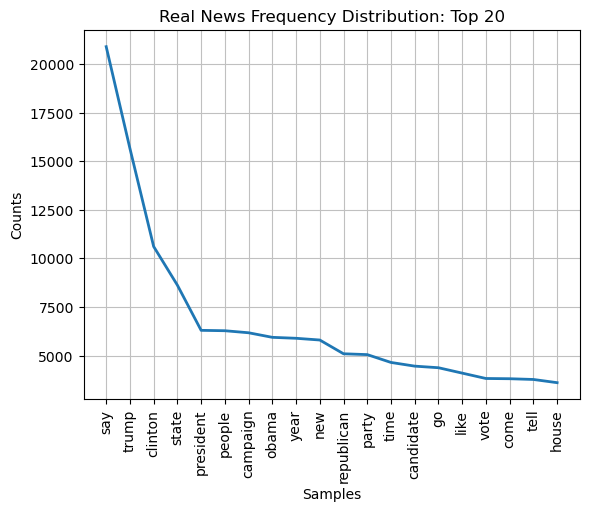

In [20]:
real_freqdist = FreqDist(real_news_words)
ax = real_freqdist.plot(20, show=False)
ax.set_title('Real News Frequency Distribution: Top 20')

Text(0.5, 1.0, 'Fake News Word Frequency Distribution: Top 20')

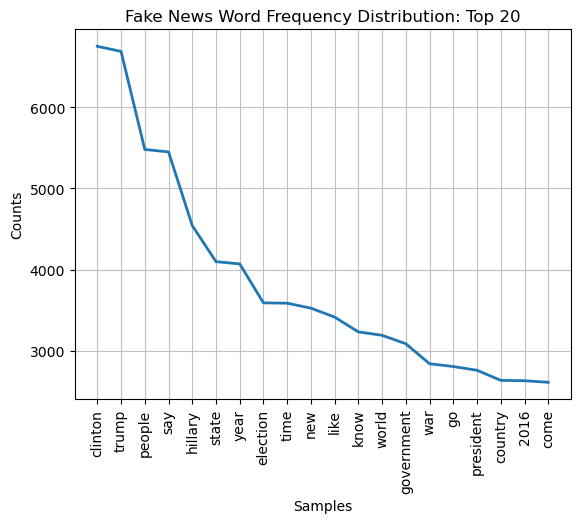

In [21]:
fake_freqdist = FreqDist(fake_news_words)
ax = fake_freqdist.plot(20, show=False)
ax.set_title('Fake News Word Frequency Distribution: Top 20')

## <u>Word Clouds

In [22]:
fake_joined = ' '.join(fake.loc[:, 'lemmas-joined'])
real_joined = ' '.join(real.loc[:, 'lemmas-joined'])
fake_joined[:50]

'trump proudly declare people insult deserved andre'

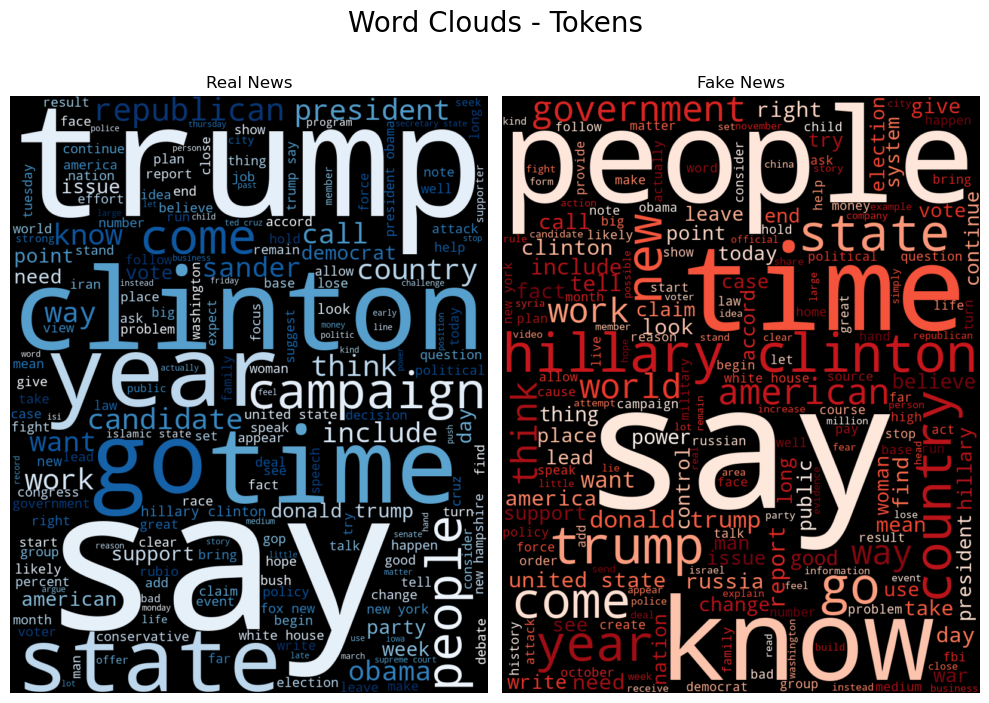

In [23]:
realcloud = WordCloud(random_state = 42,
                     width = 800,
                     height = 1000,
                     min_word_length = 2, colormap="Blues",).generate(real_joined)
fakecloud = WordCloud(random_state = 42,
                     width = 800,
                     height= 1000,
                     min_word_length = 2,
                     colormap="Reds",).generate(fake_joined)
fig, axes = plt.subplots(ncols=2, figsize=(10, 7))
axes[0].imshow(realcloud, interpolation='bilinear')
axes[0].set_title("Real News")
axes[1].imshow(fakecloud, interpolation='bilinear')
axes[1].set_title("Fake News")
[ax.axis('off') for ax in axes]
fig.tight_layout();
fig.suptitle('Word Clouds - Tokens', fontsize=20, y=1.05);

# <u><center> Text Classification with Sklearn (Core)
- Authored by: Eric N. Valdez
- Date: 4/5/2024

- ### In this assignment, you will continue with the fake news dataset you explored in the previous core assignment and will create a model to detect fake news articles.
- ### If you do this correctly, you may be able to create a model that can identify fake news articles with 80-90%+ accuracy.acy.

# <u>Steps
1. Already made a copy of core assigment 1 and ran notebook which is above.

## 2. `Prepare Imports and Functions`
- ### Import necessary packages to split, grid search, vectorize, and model your data.
- ### Add a function to evaluate a classication model. You can use the one from the Learing Platform.

# <u>Imports

In [24]:
# Additional Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

pd.set_option('display.max_colwidth',300)

# <u>Functions

In [25]:
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict

def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

In [26]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False,values_format=".2f"):
    """Modified version of classification metrics function from Intro to Machine Learning.
    Updates:
    - Reversed raw counts confusion matrix cmap  (so darker==more).
    - Added arg for normalized confusion matrix values_format
    """
    # Get the classification report
    report = classification_report(y_true, y_pred)
    
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
    # Create a confusion matrix  of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None, 
                                            cmap='gist_gray_r',# Updated cmap
                                            values_format="d", 
                                            colorbar=colorbar,
                                            ax = axes[0]);
    axes[0].set_title("Raw Counts")
    
    # Create a confusion matrix with the data with normalize argument 
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap, 
                                            values_format=values_format, #New arg
                                            colorbar=colorbar,
                                            ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict
    
    
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

## 3. `Prepare the Data`
- ### Split your data into X and y variable. Your `X` variable will be the **<u>joined lemmatized</u>** text (`NOT` the tolkenized text) you created previously and the `label` column will be your y variable.

In [40]:
def join_tokens(lemmatized_tokens):
    joined_lemmatized = ' '.join(lemmatized_tokens)
    return joined_lemmatized

X = df['lemmatized_tokens'].apply(join_tokens)
y = df['label']
X.head(10)

0    donald trump endorse unabashedly noninterventionist approach world affair monday day long tour washington cast doubt need north atlantic treaty organization express skepticism muscular u.s. military presence asia foreign policy position outline meeting editorial board washington post come day tr...
1    justice department investigation adversarial new model collaborative reform surprising police city find include solution search framework heal baltimore mayor stephanie rawlings blake 911 department justice ask civil right investigation baltimore police department beat cop tactic week local pros...
2    trump proudly declare people insult deserved andrew bradford october 27 2016 subscribe arrogance define insulting way thinking behave come believe well smart important people word donald trump perfectly exemplify arrogance prove fact appear good morning america thursday morning gop nominee readi...
3    donald trump spend day january 2014 hobnob politician trump international golf c

In [39]:
# # Define X and y
# X = df['lemmatized_tokens']
# y = df['label']

In [41]:
# Checking class balance 
y.value_counts(normalize=True)

REAL    0.500159
FAKE    0.499841
Name: label, dtype: float64

#### <u>Train Test Split

In [42]:
# Train test split
X_train_full, X_test, y_train_full, y_test = train_test_split(X,y,test_size=0.25,
                                                    random_state=321)

In [43]:
# Checking class balance
y_train_full.value_counts(normalize=True)

FAKE    0.500106
REAL    0.499894
Name: label, dtype: float64

In [44]:
from imblearn.under_sampling import RandomUnderSampler
sampler = RandomUnderSampler(random_state=42)
X_train, y_train = sampler.fit_resample(X_train_full.values.reshape(-1,1),y_train_full)
X_train = X_train.flatten()
# Check for class balance
y_train.value_counts(normalize=True)

FAKE    0.5
REAL    0.5
Name: label, dtype: float64

## 4. `Prepare parameter grids for your Grid Search.` 
- Create a pipeline with a vectorizer and a model. It doesn't matter at this point which ones, but the vectorizer step should be named 'vectorizer' and the model step should be named 'clf'.

#### <u>Vectorization

In [45]:
# instantiate a vectorizer
clf_vectorizer = CountVectorizer()
clf_vectorizer.fit(X_train)

CountVectorizer()

In [46]:
# How many words in the vocabulary?
len(clf_vectorizer.vocabulary_)

50761

In [47]:
# Transform train and test data 
X_train_counts = clf_vectorizer.transform(X_train)
X_test_counts = clf_vectorizer.transform(X_test)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=.3, random_state=42)
X_train.head()

4463    voter think clinton break law twice think trump → kimyo interpretation following email podesta 2015 cnbc interview sander state hustle money like sit restaurant like type wealth potential isolate reality world podesta keep w agreement clearly leverage good flag send signal welch establish direct...
6234    accuse boston marathon bomber dzhokhar tsarnaev go trial monday doubt outcome phase phase trial second sentencing phase include possible death sentence subject scene discussion federal prosecutor defense attorney tsarnaev hold talk possible plea agreement fail reach u.s. official familiar talk d...
6300    president obama release plan pentagon tuesday spell way united states close terrorist detention center guantanamo bay cuba send detainee include facility united states key detail plan guantanamo detainee united states plan say pentagon team inspect 13 different facility inside united states acco...
1096    highly controversial decision louisiana supreme court rule catholic 

- ## 4b. Prepare parameter grids for CountVectorizer and TfidfVectorizer
- You should tune at least 1 parameter in each vectorizer and 4 total.
- Remeber that the more parameters you tune, the longer your grid search will take.
- Also, include a parameter to tune the ngram range. This will make the vectorizer try ngrams as well as single tokens. 
    - You use the code below to add this parameter to the grid:
        - vectorizer__ngram_rannge:[(1,1),(1,2)]

In [50]:
# Instantiate CountVectorizer
countvector = CountVectorizer(min_df=4, ngram_range=(1,2))
countvector.fit(X_train)
countvector.transform(X_train)

<4414x71617 sparse matrix of type '<class 'numpy.int64'>'
	with 1501109 stored elements in Compressed Sparse Row format>

- ## 4c. Prepare the parameter grids for a MultinomialNB model and at least 1 other classification model.
    - We recommend not using an ensemble model.
    - They may end up with higher accuracy but will increase the fit time of your grid search considerably.

In [51]:
# Create a model pipeline for inference.
nbayes = MultinomialNB()

count_pipe = Pipeline([('countvectorizer', countvector), 
                       ('naivebayes', nbayes)])

count_pipe.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(min_df=4, ngram_range=(1, 2))),
                ('naivebayes', MultinomialNB())])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        FAKE       0.96      0.95      0.96      2238
        REAL       0.95      0.96      0.96      2176

    accuracy                           0.96      4414
   macro avg       0.96      0.96      0.96      4414
weighted avg       0.96      0.96      0.96      4414



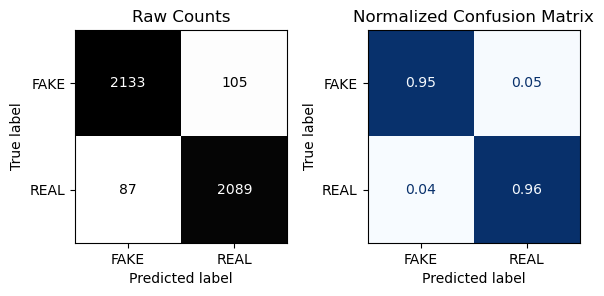


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        FAKE       0.92      0.90      0.91       620
        REAL       0.92      0.93      0.92       704

    accuracy                           0.92      1324
   macro avg       0.92      0.92      0.92      1324
weighted avg       0.92      0.92      0.92      1324



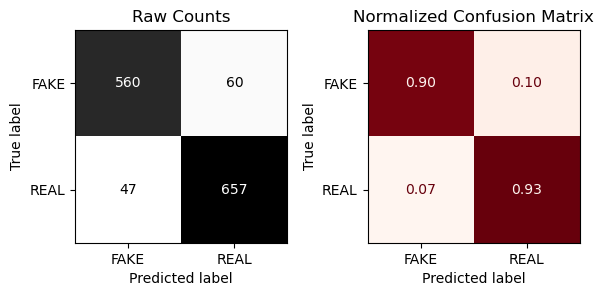

In [52]:
evaluate_classification(count_pipe, X_train, y_train, X_val, y_val)

In [53]:
# Instantiate TF-IDF Vectorizor
tfidf = TfidfVectorizer(min_df=3, ngram_range=(1,2))

tfidfbayes = MultinomialNB()

tfidf_pipe = Pipeline([('tfidfvectorizer', tfidf),
                       ('bayes_model', tfidfbayes)])

tfidf_pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(min_df=3, ngram_range=(1, 2))),
                ('bayes_model', MultinomialNB())])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        FAKE       0.98      0.92      0.95      2238
        REAL       0.92      0.98      0.95      2176

    accuracy                           0.95      4414
   macro avg       0.95      0.95      0.95      4414
weighted avg       0.95      0.95      0.95      4414



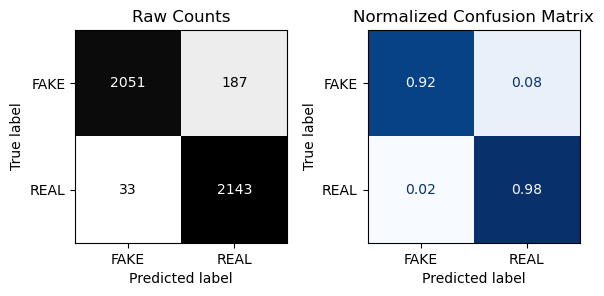


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        FAKE       0.97      0.82      0.89       620
        REAL       0.86      0.98      0.92       704

    accuracy                           0.90      1324
   macro avg       0.91      0.90      0.90      1324
weighted avg       0.91      0.90      0.90      1324



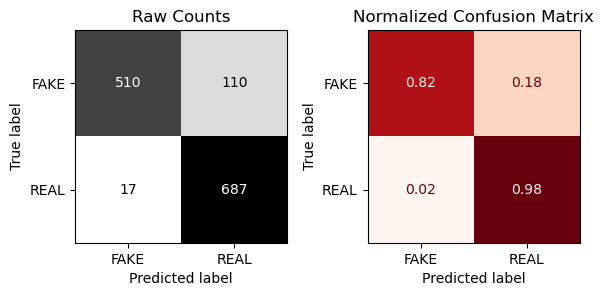

In [54]:
evaluate_classification(tfidf_pipe, X_train, y_train, X_val, y_val)

- ## 4d. Use itertools.product() to create all combinations of vectorizers nb models.

In [55]:
import itertools

In [57]:
X_train[0]

'donald trump endorse unabashedly noninterventionist approach world affair monday day long tour washington cast doubt need north atlantic treaty organization express skepticism muscular u.s. military presence asia foreign policy position outline meeting editorial board washington post come day trump set aside guerrilla tactic showman bravado power campaign appear presidential nominee explain policy accept counsel build bridge republican elite monday night trump deliver scripted address american israel public affairs committee prompt ovation pledge stand israel hard line peace talk palestinians trump whirlwind day appearance nation capital intend head establishment push deny republican party nomination post meeting billionaire mogul clear beholden gop long hold orthodoxy hour long discussion reveal foreign policy adviser trump advocate light footprint world spite unrest middle east say united states look inward steer resource rebuild nation crumble infrastructure point hey care trump sa

In [58]:
# instantiate a vectorizer with english stopwords
vectorizer = CountVectorizer(stop_words='english')

# Fit it on the data 
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        FAKE       0.96      0.92      0.94      2238
        REAL       0.92      0.96      0.94      2176

    accuracy                           0.94      4414
   macro avg       0.94      0.94      0.94      4414
weighted avg       0.94      0.94      0.94      4414



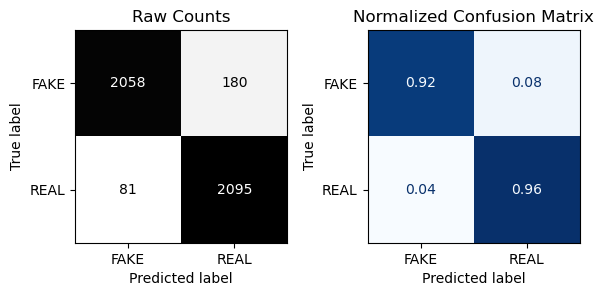


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        FAKE       0.91      0.86      0.88       294
        REAL       0.86      0.91      0.88       274

    accuracy                           0.88       568
   macro avg       0.88      0.88      0.88       568
weighted avg       0.89      0.88      0.88       568



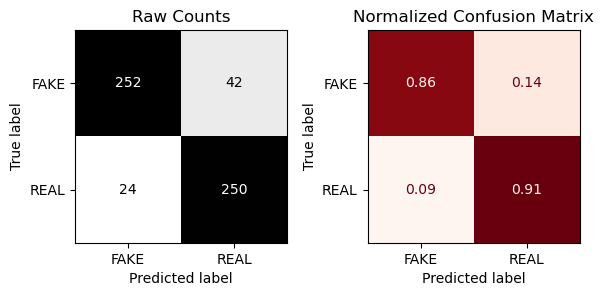

In [59]:
from sklearn.naive_bayes import MultinomialNB
clf_nb = MultinomialNB()
clf_nb.fit(X_train_vec, y_train)
evaluate_classification(clf_nb, X_train_vec,y_train, X_test_vec, y_test)

In [60]:
clf_nb.get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': 'warn'}

In [61]:
# Check class prior probabilities
class_priors = y_train.value_counts(normalize=True)
class_priors

FAKE    0.507023
REAL    0.492977
Name: label, dtype: float64

In [62]:
# Define param grid
params={'alpha': [0.001, 0.1, .5, 1, 1.5, 10, 100],
        'fit_prior': [True, False]}

- ## 4e. Use a loop to combine the parameter grids for each combination of vectorizer and model.

In [63]:
from sklearn.model_selection import GridSearchCV
#Instantiate GridSearchCV
grid_search = GridSearchCV(clf_nb, param_grid=params, n_jobs = -1, verbose = 2)
# Fit the Gridsearch on the training data
grid_search.fit(X_train_vec, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


GridSearchCV(estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.1, 0.5, 1, 1.5, 10, 100],
                         'fit_prior': [True, False]},
             verbose=2)

In [64]:
# Obtain the best combination directly
grid_search.best_params_

{'alpha': 0.001, 'fit_prior': True}

In [65]:
# See results of each combination of parameters
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_fit_prior,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.053214,0.005748,0.013731,0.003064,0.001,True,"{'alpha': 0.001, 'fit_prior': True}",0.906002,0.890147,0.899207,0.906002,0.912698,0.902811,0.007635,1
1,0.070465,0.013173,0.015879,0.001082,0.001,False,"{'alpha': 0.001, 'fit_prior': False}",0.906002,0.890147,0.898075,0.906002,0.912698,0.902585,0.007755,2
2,0.058759,0.010162,0.013470,0.005683,0.1,True,"{'alpha': 0.1, 'fit_prior': True}",0.912797,0.886750,0.892412,0.901472,0.909297,0.900546,0.009839,3
3,0.055350,0.007326,0.017423,0.001021,0.1,False,"{'alpha': 0.1, 'fit_prior': False}",0.912797,0.886750,0.890147,0.901472,0.909297,0.900093,0.010247,4
4,0.065667,0.022747,0.019976,0.009237,0.5,True,"{'alpha': 0.5, 'fit_prior': True}",0.908267,0.883352,0.884485,0.896942,0.903628,0.895335,0.009999,6


In [66]:
# Create a list of all columns containing param_
param_cols = cv_results.columns[ cv_results.columns.str.contains('param_')]
# Limit results to the mean_test_score and parameters. Use the * operator to unpack the param_cols list 
results = cv_results.loc[:, ['mean_test_score', *param_cols]].sort_values(by = 'mean_test_score', ascending = False).round(6)
results.head()

,mean_test_score,param_alpha,param_fit_prior
0,0.902811,0.001,True
1,0.902585,0.001,False
2,0.900546,0.1,True
3,0.900093,0.1,False
5,0.895562,0.5,False


In [67]:
# Create a pipeline with a vectorizer and classification model.
clf_pipe = Pipeline([('vectorizer', CountVectorizer()),
                     ('clf',MultinomialNB())])

In [68]:
clf_pipe.get_params()

{'memory': None,
 'steps': [('vectorizer', CountVectorizer()), ('clf', MultinomialNB())],
 'verbose': False,
 'vectorizer': CountVectorizer(),
 'clf': MultinomialNB(),
 'vectorizer__analyzer': 'word',
 'vectorizer__binary': False,
 'vectorizer__decode_error': 'strict',
 'vectorizer__dtype': numpy.int64,
 'vectorizer__encoding': 'utf-8',
 'vectorizer__input': 'content',
 'vectorizer__lowercase': True,
 'vectorizer__max_df': 1.0,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 1,
 'vectorizer__ngram_range': (1, 1),
 'vectorizer__preprocessor': None,
 'vectorizer__stop_words': None,
 'vectorizer__strip_accents': None,
 'vectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vectorizer__tokenizer': None,
 'vectorizer__vocabulary': None,
 'clf__alpha': 1.0,
 'clf__class_prior': None,
 'clf__fit_prior': True,
 'clf__force_alpha': 'warn'}

In [69]:
param_grid = {
    "vectorizer__max_df": [ 0.75, 0.85, 0.95],
    'vectorizer__min_df': [ 2, 3, 4 ], 
    "vectorizer__max_features": [None, 500, 1000, 2000],
    "vectorizer__ngram_range": [(1, 1), (1, 2),(2,2)],
    "vectorizer__stop_words": [None,'english'],
    "clf__alpha": [.5, 1]
}

## 5. `Create the best model using GridSearchCV`
- ### a. Find the best combination of vectorizer, model, and hyperameters for each to create the most accurate model.
    - This step may take between <u>15 and 30 minutes</u> or even more, depending on how many parameters you choose to tune. 

In [71]:
# Addditional Imports:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
# Set pandas as the default output for sklearn
from sklearn import set_config
set_config(transform_output='pandas')

In [72]:
def regression_metrics(y_true, y_pred, label='', verbose = True, output_dict=False):
  # Get metrics
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False) 
  r_squared = r2_score(y_true, y_pred)
  if verbose == True:
    # Print Result with Label and Header
    header = "-"*60
    print(header, f"Regression Metrics: {label}", header, sep='\n')
    print(f"- MAE = {mae:,.3f}")
    print(f"- MSE = {mse:,.3f}")
    print(f"- RMSE = {rmse:,.3f}")
    print(f"- R^2 = {r_squared:,.3f}")
  if output_dict == True:
      metrics = {'Label':label, 'MAE':mae,
                 'MSE':mse, 'RMSE':rmse, 'R^2':r_squared}
      return metrics
      
def evaluate_regression(reg, X_train, y_train, X_test, y_test, verbose = True,
                        output_frame=False):
  # Get predictions for training data
  y_train_pred = reg.predict(X_train)

 # Call the helper function to obtain regression metrics for training data
  results_train = regression_metrics(y_train, y_train_pred, verbose = verbose,
                                     output_dict=output_frame,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = reg.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = regression_metrics(y_test, y_test_pred, verbose = verbose,
                                  output_dict=output_frame,
                                    label='Test Data' )
  
  # Store results in a dataframe if ouput_frame is True
  if output_frame:
    results_df = pd.DataFrame([results_train,results_test])
    # Set the label as the index 
    results_df = results_df.set_index('Label')
    # Set index.name to none to get a cleaner looking result
    results_df.index.name=None
    # Return the dataframe
    return results_df.round(3)

In [73]:
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict

def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

In [74]:
%%time
# Create grid search
grid_search = GridSearchCV(clf_pipe, param_grid, cv=3,verbose=2, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
CPU times: total: 1min 13s
Wall time: 30min 4s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'clf__alpha': [0.5, 1],
                         'vectorizer__max_df': [0.75, 0.85, 0.95],
                         'vectorizer__max_features': [None, 500, 1000, 2000],
                         'vectorizer__min_df': [2, 3, 4],
                         'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'vectorizer__stop_words': [None, 'english']},
             verbose=2)

In [75]:
grid_search.best_params_

{'clf__alpha': 0.5,
 'vectorizer__max_df': 0.75,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 3,
 'vectorizer__ngram_range': (2, 2),
 'vectorizer__stop_words': 'english'}

- ### 5b. Print out your best combination of vectorizer, model, and parameters for each.
    - Refer to [this lesson](http://localhost:8888/edit/Data/GridSearchCV%20and%20Model%20Pipelines%20_%20Wk%202_%20Regression%20Models.pdf) if you need a refresher on GridSearchCV 

## 6. `Evaluate your model with your evaluation function.`

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        FAKE       0.99      0.98      0.99      2238
        REAL       0.98      0.99      0.99      2176

    accuracy                           0.99      4414
   macro avg       0.99      0.99      0.99      4414
weighted avg       0.99      0.99      0.99      4414



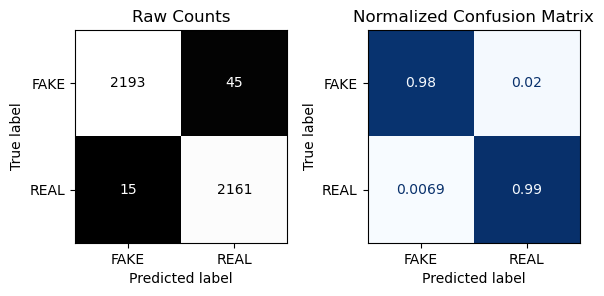


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        FAKE       0.95      0.88      0.92       294
        REAL       0.88      0.95      0.92       274

    accuracy                           0.92       568
   macro avg       0.92      0.92      0.92       568
weighted avg       0.92      0.92      0.92       568



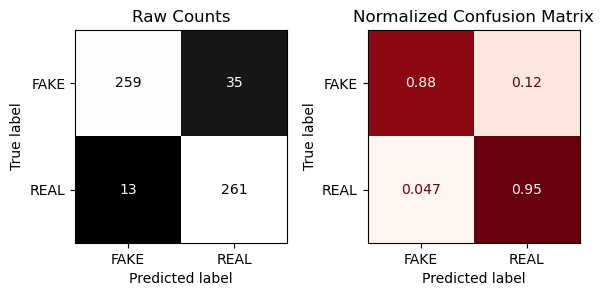

In [76]:
# Now define the best version of the model
best_model = grid_search.best_estimator_

# Predict and Evaluate with the custom function
evaluate_classification(best_model, X_train, y_train, X_test, y_test)